<a href="https://colab.research.google.com/github/sunhuanhuan920/ECE1512_2023F_ProjectRepo_Zhenhuan_Sun/blob/main/Project%20A/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 1: Knowledge Distillation in MNIST Dataset**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Question 1

(a). Transfer the knowledge from a large and cumbersome model to a model that is smaller and more suitable for deployment.

(b). The class probabilities produced by the cumbersome model.

(c).

\begin{equation}
\lim_{T \to \infty} \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)} = \frac{\exp(0)}{\sum_j \exp(0)} = \frac{1}{K}
\end{equation}

where $K$ denotes the number of classes. Thus, from this we can see that $T$ is a scaling factor that will make the probability distribution acorss all classes become closer to a uniform distribution.

We use $T$ to soften the probability distribution over classes, so that the class probabilities become less sharp and the differences in probabilities can be smoothed out.

By using a large value of $T$, the differences between the probabilities of wrong classes are emphasized, the output class probabilities that used to be very small and have very little impact on the cross-entropy cost function will become larger and have a more pronounced impact on the cost function during knowledge distillation. As a result, during knowledge distillation, the student model focus on learning how to mimic teacher model's behavior to produce similar distribution of probabilities over classes for a same input, or in other words, how to think in the same way as the teacher model does. Through this, the student model will be more capable of learning how the teacher model perceives the difference between classes, and how it generalizes to different data.

(d). The loss function comprises two parts, the first part, which is called distillation loss, is defined as

\begin{equation}
L^{(distillation)}(\mathbf{x}|T) = -\sum_{i=1}^K q_i(\mathbf{x}|T) \log(p_i(\mathbf{x}|T))
\end{equation}

where $q_i(\mathbf{x}|T)$ is the softened probability for class $i$ given input vector $\mathbf{x}$ and distillation temperature $T$ from the teacher model, and $p_i(\mathbf{x}|T)$ is the student model's softened probability for class $i$ given same input vector and distillation temperature. Cross entropy is used to measure the difference between the student's softened probability distribution and the teacher's softened probability distribution over all classes.

The second part, which is sometimes referred as classification loss, is defined as

\begin{equation}
L^{(classification)}(\mathbf{x}|T=1) = -\sum_{i=1}^K y_i \log(p_i(\mathbf{x}|T=1))
\end{equation}

where $y_i$ is the $i$ th element of the one-hot vector. Cross entropy is used to measure the difference between student model's unsoftened ($T = 1$) predicted probability distribution for different classes and the true class probability distribution, e.g., one-hot vector.

The combined loss function is defined as

\begin{equation}
L(\mathbf{x}|T) = \lambda T^2 \cdot L^{(distillation)}(\mathbf{x}|T) + (1 - \lambda) \cdot L^{(classification)}(\mathbf{x}|1)
\end{equation}

where weight parameter ($\lambda$), i.e.,task balance parameter, is introduced to combined the distillation loss and classification loss. In addition, the distillation loss is scaled by a factor of $T^2$ in the weighted sum to compensate for the gradient's down scale by a factor of $1/T^2$ due to the present of $T$ in the softmax function.

The task balance parameter governs the relative contribution of distillation loss and classification loss in the overall kownledge distillation process. When $\lambda$ equals to 1, the student model focuses on distillation and is trained only using the kownledge from the teacher model. When $\lambda$ equals to 0, the student model is trained regularly using labeled data. By adjusting $\lambda$ between $0$ and $1$, we can control how much of the teacher model's knowledge versus the acutal data we want the student to focus on during its training.

(e). The use of soft targets allows student model to account for the relative probabilites of different classes in the teacher model's output and have a deeper understanding of how teacher model thinks and generalizes on different data. Thus, by performing knowledge distillation from teacher model to student model, we are essentially letting teacher model to teach student model how to mimic its behavior to generalize as it does. This is equivalent to the effect of regularization, where we add regularization term to prevent model from memorizing the training data, so that the model can generalize well.

# Question 2

**Load dataset**

In [56]:
# import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Union

# tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

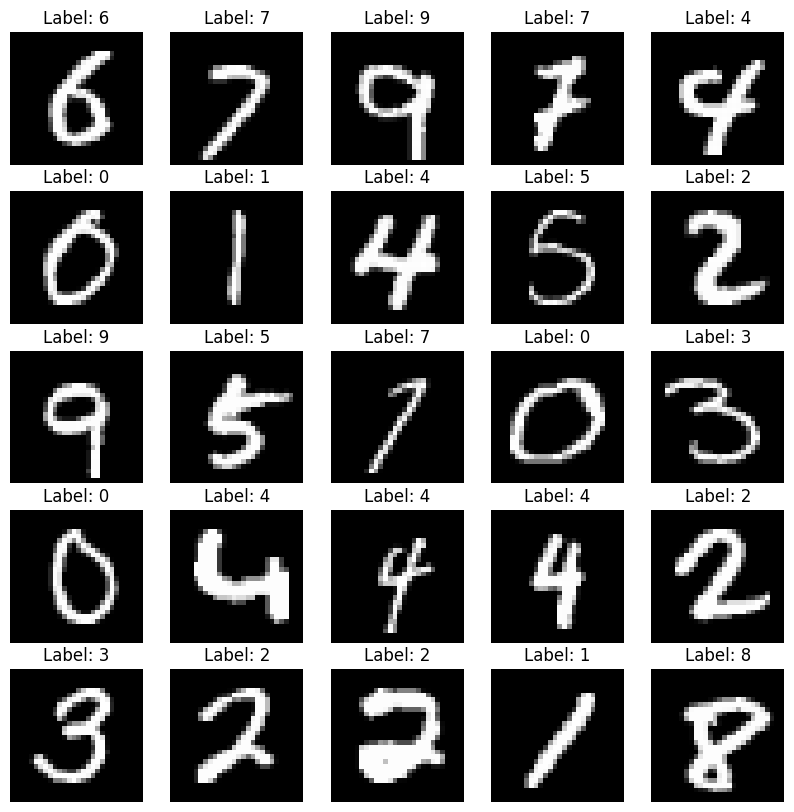

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from mnist_train
for images, labels in mnist_train.take(1):
    plt.figure(figsize=(10, 10))
    # Visualize the first 25 images from the batch
    for i in range(25):
        # print(images[i].shape)
        # print(labels[i].shape)
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title('Label: %d' % tf.argmax(labels[i]))
        plt.axis('off')
    plt.show()

**Model creation**

In [58]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential([

    # Each image in MINIST dataset has shape of (28, 28, 1)
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),

    tf.keras.layers.Dropout(rate=0.5),
    # There are 10 classes in MINIST dataset
    tf.keras.layers.Dense(10)
])

# your code start from here for stpe 2


# Build fully connected student.
fc_model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(units=784, activation='relu'),

    tf.keras.layers.Dense(units=784, activation='relu'),

    # There are 10 classes in MINIST dataset
    tf.keras.layers.Dense(10)
])

# your code start from here for step 2

# Question 3

**Teacher loss function**

In [59]:
@tf.function
def compute_teacher_loss(images, labels):
    """Compute subclass knowledge distillation teacher loss for given images
       and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    subclass_logits = cnn_model(images, training=True)

    # your code start from here for step 3
    # Compute cross-entropy loss for classes.
    cross_entropy_loss_value = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)
    )

    return cross_entropy_loss_value

**Student loss function**

In [60]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.9 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 20. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    """Compute distillation loss.

    This function computes cross entropy between softened logits and softened
    targets. The resulting loss is scaled by the squared temperature so that
    the gradient magnitude remains approximately constant as the temperature is
    changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
    a neural network."

    Args:
      teacher_logits: A Tensor of logits provided by the teacher.
      student_logits: A Tensor of logits provided by the student, of the same
        shape as `teacher_logits`.
      temperature: Temperature to use for distillation.

    Returns:
      A scalar Tensor containing the distillation loss.
    """
    # your code start from here for step 3
    soft_targets = tf.nn.softmax(teacher_logits / temperature)

    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
    """Compute subclass knowledge distillation student loss for given images
      and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    student_subclass_logits = fc_model(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass probabilities.

    # your code start from here for step 3

    teacher_subclass_logits = cnn_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Compute cross-entropy loss with hard labels.

    # your code start from here for step 3

    cross_entropy_loss_value = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
    )

    combined_loss = ALPHA * distillation_loss_value + (1 - ALPHA) * cross_entropy_loss_value

    return combined_loss

# Question 4

**Train and evaluation**

In [61]:
NUM_EPOCHS = 12

@tf.function
def compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
      model: Instance of tf.keras.Model.
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Number of correctly classified images.
    """
    class_logits = model(images, training=False)
    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
                tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
      model: Instance of tf.keras.Model.
      compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """

    # your code start from here for step 4
    # Initialize Adam optimizer with learning rate of 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    test_accuracies = []

    for epoch in range(1, NUM_EPOCHS + 1):
      # Run training.
      print('Epoch {}: '.format(epoch), end='')
      for images, labels in mnist_train:
        # For backpropagation
        # Records the operations performed inside its block to compute gradients
        with tf.GradientTape() as tape:
          # your code start from here for step 4

          # Compute loss
          loss_value = compute_loss_fn(images, labels)

        # Use the recorded operations to compute the gradients
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Run evaluation.
      num_correct = 0
      num_total = builder.info.splits['test'].num_examples
      for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct_batch, _, _ = compute_num_correct(model, images, labels)
        num_correct += num_correct_batch

      test_accuracy = num_correct / num_total * 100
      print("Class_accuracy: " + '{:.2f}%'.format(test_accuracy))
      test_accuracies.append(test_accuracy)

    return test_accuracies


# Question 5

**Training models**

In [62]:
# your code start from here for step 5

# Train teacher model
print("Training Teacher Model")
teacher_test_accuracies = train_and_evaluate(cnn_model, compute_teacher_loss)

# Train student model
print("\nTraining Student Model")
student_test_accuracies = train_and_evaluate(fc_model, compute_student_loss)

Training Teacher Model
Epoch 1: Class_accuracy: 98.35%
Epoch 2: Class_accuracy: 98.72%
Epoch 3: Class_accuracy: 98.92%
Epoch 4: Class_accuracy: 98.97%
Epoch 5: Class_accuracy: 99.00%
Epoch 6: Class_accuracy: 98.98%
Epoch 7: Class_accuracy: 99.18%
Epoch 8: Class_accuracy: 99.23%
Epoch 9: Class_accuracy: 99.15%
Epoch 10: Class_accuracy: 99.17%
Epoch 11: Class_accuracy: 99.17%
Epoch 12: Class_accuracy: 99.32%

Training Student Model
Epoch 1: Class_accuracy: 96.59%
Epoch 2: Class_accuracy: 97.81%
Epoch 3: Class_accuracy: 98.05%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.51%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.59%
Epoch 8: Class_accuracy: 98.64%
Epoch 9: Class_accuracy: 98.68%
Epoch 10: Class_accuracy: 98.71%
Epoch 11: Class_accuracy: 98.78%
Epoch 12: Class_accuracy: 98.68%


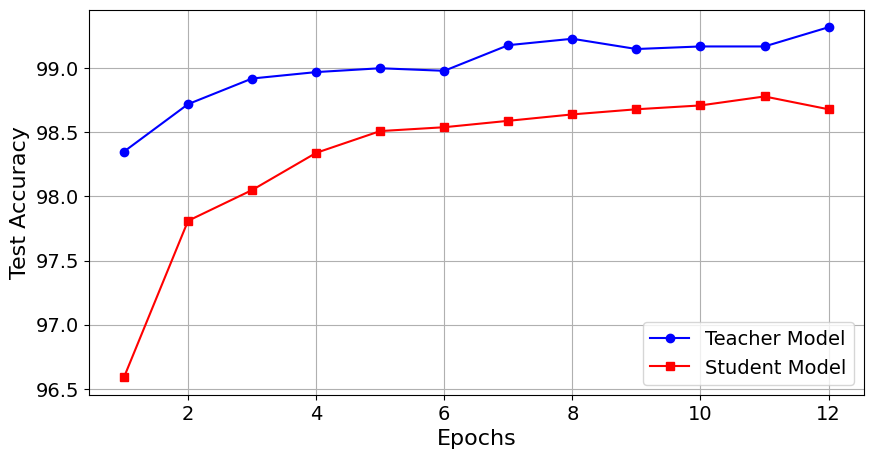

In [63]:
epochs = list(range(1, 13))

plt.figure(figsize=(10, 5))
plt.plot(epochs, teacher_test_accuracies, marker='o', linestyle='-', color='b', label='Teacher Model')
plt.plot(epochs, student_test_accuracies, marker='s', linestyle='-', color='r', label='Student Model')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
# plt.title('Test Accuracy vs. Number of Epochs')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)


plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T1Q5.png', dpi=300, bbox_inches='tight')

plt.show()

# Question 6

**Test accuracy vs. tempreture curve**

In [21]:
# I modified the train_and_evaluate function to save and return the class accuracies
# obtained during evalution for all epoches
def train_and_evaluate_2(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
      model: Instance of tf.keras.Model.
      compute_loss_fn: A function that computes the training loss given the
        images, and labels.

    Returns:
      List of evaluation accuracies for each epoch.
    """
    epoch_accuracies = []

    # Initialize Adam optimizer with learning rate of 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(1, NUM_EPOCHS + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Run evaluation.
        num_correct = 0
        num_total = builder.info.splits['test'].num_examples
        for images, labels in mnist_test:
            num_correct_batch, _, _ = compute_num_correct(model, images, labels)
            num_correct += num_correct_batch
        accuracy = num_correct / num_total * 100
        epoch_accuracies.append(accuracy)
        print("Class_accuracy: " + '{:.2f}%'.format(accuracy ))

    return epoch_accuracies


Training the student model with T = 1...
Epoch 1: Class_accuracy: 98.76%
Epoch 2: Class_accuracy: 98.87%
Epoch 3: Class_accuracy: 98.78%
Epoch 4: Class_accuracy: 99.03%
Epoch 5: Class_accuracy: 99.04%
Epoch 6: Class_accuracy: 98.96%
Epoch 7: Class_accuracy: 98.93%
Epoch 8: Class_accuracy: 98.92%
Epoch 9: Class_accuracy: 98.95%
Epoch 10: Class_accuracy: 98.97%
Epoch 11: Class_accuracy: 98.92%
Epoch 12: Class_accuracy: 99.02%
Average Test accuracy for T=1: 98.92917

Training the student model with T = 2...
Epoch 1: Class_accuracy: 98.97%
Epoch 2: Class_accuracy: 99.01%
Epoch 3: Class_accuracy: 99.02%
Epoch 4: Class_accuracy: 98.99%
Epoch 5: Class_accuracy: 99.09%
Epoch 6: Class_accuracy: 99.01%
Epoch 7: Class_accuracy: 99.01%
Epoch 8: Class_accuracy: 99.06%
Epoch 9: Class_accuracy: 98.96%
Epoch 10: Class_accuracy: 99.03%
Epoch 11: Class_accuracy: 99.01%
Epoch 12: Class_accuracy: 98.93%
Average Test accuracy for T=2: 99.00751

Training the student model with T = 4...
Epoch 1: Class_accur

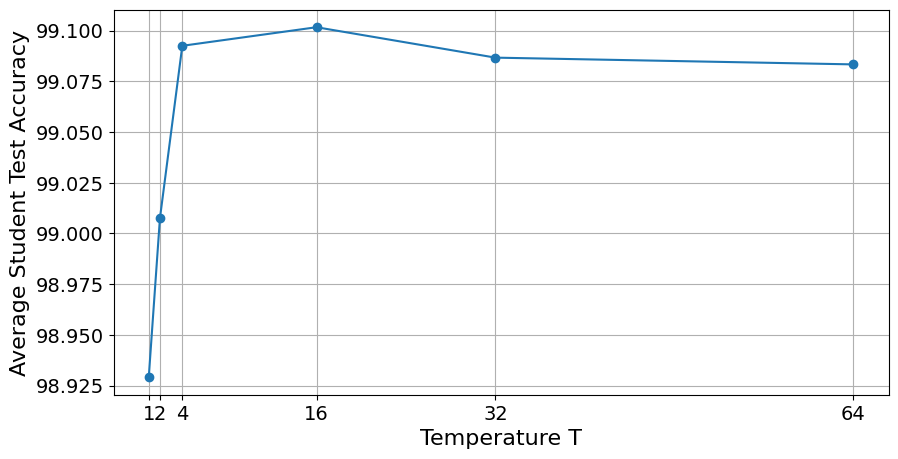

In [22]:
ALPHA = 0.5
temperatures = [1, 2, 4, 16, 32, 64]
accuracies = []

for T in temperatures:

    DISTILLATION_TEMPERATURE = T

    # Train and evaluate student model
    print(f"\nTraining the student model with T = {T}...")
    epoch_accuracies = train_and_evaluate_2(fc_model, compute_student_loss)

    # Compute the average accuracy over all epochs for this temperature
    avg_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)
    accuracies.append(avg_accuracy)
    print(f"Average Test accuracy for T={T}: {avg_accuracy:.5f}")

# Plotting the curve
plt.figure(figsize=(10, 5))
plt.plot(temperatures, accuracies, marker='o')
plt.xlabel('Temperature T', fontsize=16)
plt.ylabel('Average Student Test Accuracy', fontsize=16)
# plt.title('Average Student Test Accuracy vs. Temperature Hyperparameter')
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(temperatures) # Set x-ticks to the specified temperatures only
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T1Q6.png', dpi=300, bbox_inches='tight')
plt.show()

# Question 7

**Train student from scratch**

In [23]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(units=784, activation='relu'),

    tf.keras.layers.Dense(units=784, activation='relu'),

    # There are 10 classes in MINIST dataset
    tf.keras.layers.Dense(10)
])

# your code start from here for step 7

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
  )

  return cross_entropy_loss

plain_student_test_accuracies = train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.45%
Epoch 2: Class_accuracy: 97.39%
Epoch 3: Class_accuracy: 98.19%
Epoch 4: Class_accuracy: 97.99%
Epoch 5: Class_accuracy: 98.11%
Epoch 6: Class_accuracy: 98.04%
Epoch 7: Class_accuracy: 98.04%
Epoch 8: Class_accuracy: 97.57%
Epoch 9: Class_accuracy: 97.98%
Epoch 10: Class_accuracy: 98.00%
Epoch 11: Class_accuracy: 97.90%
Epoch 12: Class_accuracy: 97.95%


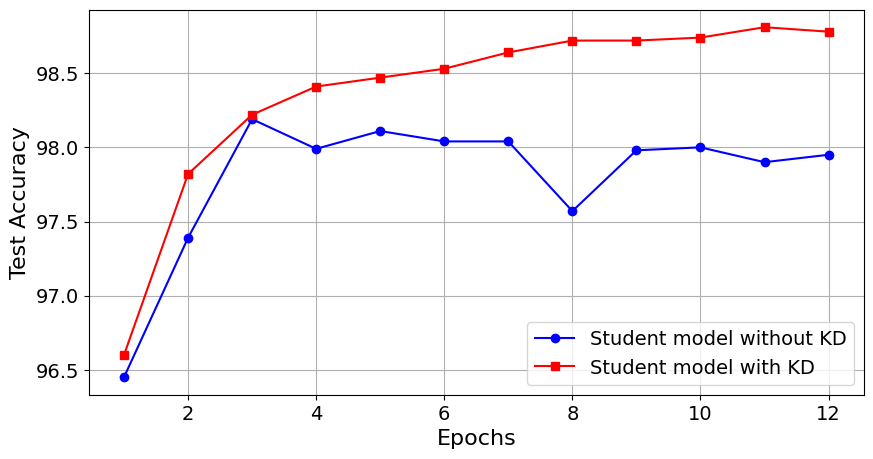

In [24]:
epochs = list(range(1, 13))

plt.figure(figsize=(10, 5))
plt.plot(epochs, plain_student_test_accuracies, marker='o', linestyle='-', color='b', label='Student model without KD')
plt.plot(epochs, student_test_accuracies, marker='s', linestyle='-', color='r', label='Student model with KD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
# plt.title('Test Accuracy vs. Number of Epochs')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)


plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T1Q7.png', dpi=300, bbox_inches='tight')

plt.show()

# Question 8

**Comparing the teacher and student model (number of of parameters)**

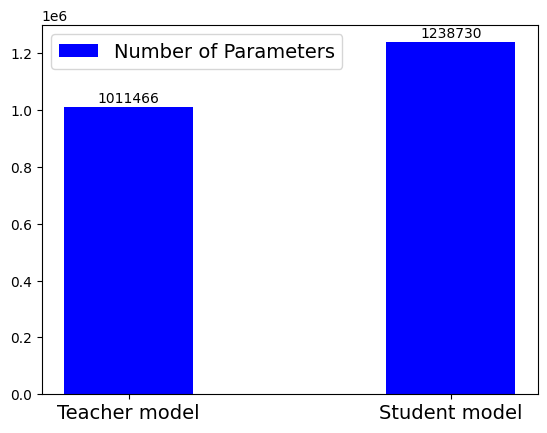

In [33]:
# Number of parameter comparison
params_teacher_model = cnn_model.count_params()
params_student_model = fc_model.count_params()

labels = ['Teacher model', 'Student model']
params = [params_teacher_model, params_student_model]

x = range(len(labels))

# Create bar plot
bars = plt.bar(x, params, width=0.4, label='Number of Parameters', color='b', align='center')

# Add exact numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005 * max(params), round(yval, 2), ha='center', va='bottom', fontsize=10)

# plt.xlabel('Models', fontsize=16)
# plt.title('Number of parameter comparison')
plt.xticks(x, labels, fontsize=14)
plt.legend(fontsize=14)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T1Q8.png', dpi=300, bbox_inches='tight')
plt.show()

**Comparing the teacher and student model (FLOPs)**

Reference:

[1] Tokusumi. (2020). keras-flops. GitHub. https://github.com/tokusumi/keras-flops

In [34]:
# [1]
from typing import Optional, Union
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import (
    convert_variables_to_constants_v2_as_graph,
)

from tensorflow.keras import Sequential, Model
import logging
tf.get_logger().setLevel(logging.ERROR)

# import keras_flops.flops_registory

def get_flops(model: Union[Model, Sequential], batch_size: Optional[int] = None) -> int:
    """
    Calculate FLOPS for tf.keras.Model or tf.keras.Sequential .
    Ignore operations used in only training mode such as Initialization.
    Use tf.profiler of tensorflow v1 api.
    """
    if not isinstance(model, (Sequential, Model)):
        raise KeyError(
            "model arguments must be tf.keras.Model or tf.keras.Sequential instanse"
        )

    if batch_size is None:
        batch_size = 1

    # convert tf.keras model into frozen graph to count FLOPS about operations used at inference
    # FLOPS depends on batch size
    inputs = [
        tf.TensorSpec([batch_size] + inp.shape[1:], inp.dtype) for inp in model.inputs
    ]
    real_model = tf.function(model).get_concrete_function(inputs)
    frozen_func, _ = convert_variables_to_constants_v2_as_graph(real_model)

    # Calculate FLOPS with tf.profiler
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(
        graph=frozen_func.graph, run_meta=run_meta, cmd="scope", options=opts
    )
    # print(frozen_func.graph.get_operations())
    # TODO: show each FLOPS
    return flops.total_float_ops

FLOPs for CNN model: 22,042,058
FLOPs for FC model: 2,475,882


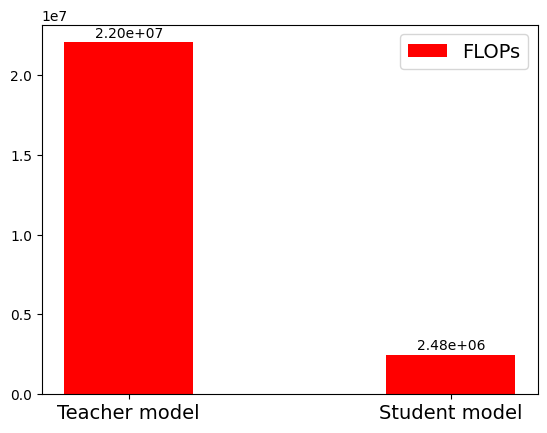

In [35]:
# Calculate FLOPs for each model
cnn_flops = get_flops(cnn_model)
fc_flops = get_flops(fc_model)

print("FLOPs for CNN model: {:,}".format(cnn_flops))
print("FLOPs for FC model: {:,}".format(fc_flops))

labels = ['Teacher model', 'Student model']
flops = [cnn_flops, fc_flops]

x = range(len(labels))

# Create bar plot
bars = plt.bar(x, flops, width=0.4, label='FLOPs', color='r', align='center')

# Add exact numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005 * max(flops), f'{yval:.2e}', ha='center', va='bottom', fontsize=10)

# plt.xlabel('Models')
# plt.title('FLOPs comparison')
plt.xticks(x, labels, fontsize=14)
plt.legend(fontsize=14)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T1Q8_2.png', dpi=300, bbox_inches='tight')
plt.show()

# Question 9 ~ 11

The paper I chose to read is:

[2] Müller, R., Kornblith, S., & Hinton, G. (2020). Subclass distillation. arXiv preprint arXiv:2002.03936.

9. Building upon the idea of conventional knowledge distillation, subclass distillation still treats class probabilities as knowledge for distillation, however instead of using the probabilities of the main classes, it forces the teacher to divide exisiting classes into many subclasses, and the probability distribution across all subclasses is transferred from the teacher model to the student model. The intuition is that subclasses may be able to capture finer-grained aspects or details within each main class, providing richer information for the student to learn from.

10. In essence, subclass distillation takes the idea of knowledge distillation a step further by introducing subclasses to capture more fine-grained knowledge from the teacher model, enabling better transfer of knowledge to the student model. This is especially useful for classification problems that only have a few classes, as the additional subclassess can allow more information to be transferred from teacher model to student model.

11. Introducing subclasses can increase the complexity of knowledge distillation process. For subclass distillation to be effective, moredata may be required to represent each subclass adequately. In addition, it can be challenging to determine how many subclasses to use and how to define them. To address these issues, collecting data can be helpful and validation data can be used to help decide on the optimal number of subclasses. Techniques like clustering algorithms (e.g., k-means) on feature representations from the teacher model can also assist in defining meaningful subclasses.

# Question 12

**Implementing the state-of-the-art KD algorithm**

**Model Creation**

In [76]:
# When there are too many subclasses(classes), the logits or softmax outputs for each subclass become
# smaller, which can lead to numerical instability, vanish gradient or exploding gradient.
# NUM_SUBCLASSES_PER_CLASS = 5 is a sweet point I found for MINIST dataset.
# A large number of classes might necessitate a model with a greater capacity to
# distinguish between them. I need to increase the capacity of the model by adding
# more layers or neurons, and ensure that the model architecture is suited for the
# complexity of the dataset.

# The number of subclasses per class (Hyperparameter)
NUM_SUBCLASSES_PER_CLASS = 5

# Build CNN teacher.
# Adjust the last layer of teacher model to output a number of c * s logits
SD_cnn_model = tf.keras.Sequential([

    # Each image in MINIST dataset has shape of (28, 28, 1)
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),

    tf.keras.layers.Dropout(rate=0.5),
    # There are 10 classes in MINIST dataset
    # In total, there are 10 * NUM_SUBCLASSES_PER_CLASS subclasses
    tf.keras.layers.Dense(10 * NUM_SUBCLASSES_PER_CLASS)
])

# Build fully connected student.
SD_fc_model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(units=784, activation='relu'),

    tf.keras.layers.Dense(units=784, activation='relu'),

    # There are 10 classes in MINIST dataset
    # In total, there are 10 * NUM_SUBCLASSES_PER_CLASS subclasses
    tf.keras.layers.Dense(10 * NUM_SUBCLASSES_PER_CLASS)
])

# your code start from here for stpe 2

**Teacher loss function for subclass distillation**

In [77]:
@tf.function
def compute_teacher_loss(images, labels):
    """Compute subclass knowledge distillation teacher loss for given images
       and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    # It has shape [batch size, c x s]
    subclass_logits = SD_cnn_model(images, training=True)
    # tf.print(subclass_logits)

    # Compute softmax probabilities across all classes and subclasses.
    softmax_probs = tf.nn.softmax(subclass_logits)

    # Reshape probabilities to [batch_size, c, s].
    softmax_probs = tf.reshape(softmax_probs, [-1, 10, NUM_SUBCLASSES_PER_CLASS])

    # Compute the sum of softmax probabilities across the subclasses for each class.
    # The resulting shape is [batch_size, c]
    summed_probs = tf.reduce_sum(softmax_probs, axis=-1)
    # print(summed_probs)
    # tf.print(summed_probs)

    # Compute the cross-entropy loss using the summed probabilities.
    cross_entropy_loss = -tf.math.reduce_mean(tf.reduce_sum(labels * tf.math.log(summed_probs + 1e-9), axis=-1))
    # tf.print(cross_entropy_loss)

    # Normalize the logits
    mean, variance = tf.nn.moments(subclass_logits, axes=[1], keepdims=True)
    normalized_subclass_logits = (subclass_logits - mean) / tf.sqrt(variance + 1e-9)
    # print(normalized_subclass_logits)

    batch_size = tf.shape(normalized_subclass_logits)[0]
    T = 1.0

    # Compute the temperature-scaled logits product matrix
    logits_product_matrix = tf.matmul(normalized_subclass_logits, tf.transpose(normalized_subclass_logits)) / T

    # Compute the exponentiated logits product matrix
    exp_logits_product_matrix = tf.exp(logits_product_matrix)

    # Compute the numerators: diagonal elements of the matrix represent e^{\vec{v_i}^T\vec{v_i}/T}
    numerators = tf.linalg.diag_part(exp_logits_product_matrix)

    # Compute the denominators: mean of each row
    denominators = tf.reduce_mean(exp_logits_product_matrix, axis=-1)

    # Compute the auxiliary loss for each vector in the batch
    aux_losses = tf.math.log(numerators / denominators)

    # Compute the mean auxiliary loss across the batch
    L_aux = -tf.reduce_mean(aux_losses)

    beta = 0.1
    total_loss = cross_entropy_loss + beta * L_aux

    return total_loss

**Student loss function for subclass distillation**

In [78]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.9 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 20. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    """
    Args:
      teacher_logits: A Tensor of logits provided by the teacher.
      student_logits: A Tensor of logits provided by the student, of the same
        shape as `teacher_logits`.
      temperature: Temperature to use for distillation.

    Returns:
      A scalar Tensor containing the distillation loss.
    """

    # Soft labels from teacher logits
    teacher_softmax_probs = tf.nn.softmax(teacher_logits / temperature)
    teacher_softmax_probs = tf.reshape(teacher_softmax_probs, [-1, 10, NUM_SUBCLASSES_PER_CLASS])

    # Probabilities from student logits
    student_softmax_probs = tf.nn.softmax(student_logits / temperature)
    student_softmax_probs = tf.reshape(student_softmax_probs, [-1, 10, NUM_SUBCLASSES_PER_CLASS])

    # Compute the distillation loss term for each example, class, and subclass
    loss_terms = teacher_softmax_probs * tf.math.log(student_softmax_probs + 1e-9)

    # Sum over all examples, classes, and subclasses
    distillation_loss = -temperature ** 2 * tf.math.reduce_mean(tf.reduce_sum(loss_terms, axis=[1, 2]))

    return distillation_loss

def compute_student_loss(images, labels):
    """Compute subclass knowledge distillation student loss for given images
      and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    student_subclass_logits = SD_fc_model(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits = SD_cnn_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Compute cross-entropy loss with hard labels.
    softmax_probs = tf.nn.softmax(student_subclass_logits)
    softmax_probs = tf.reshape(softmax_probs, [-1, 10, NUM_SUBCLASSES_PER_CLASS])
    summed_probs = tf.reduce_sum(softmax_probs, axis=-1)

    # Compute the cross-entropy loss using the summed probabilities.
    cross_entropy_loss_value = -tf.math.reduce_mean(tf.reduce_sum(labels * tf.math.log(summed_probs + 1e-9), axis=-1))

    combined_loss = ALPHA * distillation_loss_value + (1 - ALPHA) * cross_entropy_loss_value

    return combined_loss

**Train and evaluation for subclass distillation**

In [79]:
NUM_EPOCHS = 12

@tf.function
def compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
      model: Instance of tf.keras.Model.
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Number of correctly classified images.
    """
    subclass_logits = model(images, training=False)

    # Compute softmax probabilities across all classes and subclasses.
    softmax_probs = tf.nn.softmax(subclass_logits)

    # Reshape probabilities to [batch_size, c, s].
    softmax_probs = tf.reshape(softmax_probs, [-1, 10, NUM_SUBCLASSES_PER_CLASS])

    # Compute the sum of softmax probabilities across the subclasses for each class.
    class_probs = tf.reduce_sum(softmax_probs, axis=-1)

    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_probs, -1), tf.argmax(labels, -1)),
                tf.float32)), tf.argmax(class_probs, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
      model: Instance of tf.keras.Model.
      compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """

    # your code start from here for step 4
    # Initialize Adam optimizer with learning rate of 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    test_accuracies = []

    for epoch in range(1, NUM_EPOCHS + 1):
      # Run training.
      print('Epoch {}: '.format(epoch), end='')
      for images, labels in mnist_train:
        # For backpropagation
        # Records the operations performed inside its block to compute gradients
        with tf.GradientTape() as tape:
          # your code start from here for step 4

          # Compute loss
          loss_value = compute_loss_fn(images, labels)

        # print(loss_value)
        # Use the recorded operations to compute the gradients
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Run evaluation.
      num_correct = 0
      num_total = builder.info.splits['test'].num_examples
      for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct_batch, _, _ = compute_num_correct(model, images, labels)
        num_correct += num_correct_batch

      test_accuracy = num_correct / num_total * 100
      print("Class_accuracy: " + '{:.2f}%'.format(test_accuracy))
      test_accuracies.append(test_accuracy)

    return test_accuracies

**Training models for subclass distillation**

In [80]:
# Train teacher model
print("Training Teacher Model")
SD_teacher_test_accuracies = train_and_evaluate(SD_cnn_model, compute_teacher_loss)

# Train student model
print("\nTraining Student Model")
SD_student_test_accuracies = train_and_evaluate(SD_fc_model, compute_student_loss)

Training Teacher Model
Epoch 1: Class_accuracy: 98.02%
Epoch 2: Class_accuracy: 98.55%
Epoch 3: Class_accuracy: 98.79%
Epoch 4: Class_accuracy: 98.84%
Epoch 5: Class_accuracy: 99.04%
Epoch 6: Class_accuracy: 99.03%
Epoch 7: Class_accuracy: 99.08%
Epoch 8: Class_accuracy: 99.05%
Epoch 9: Class_accuracy: 99.18%
Epoch 10: Class_accuracy: 99.12%
Epoch 11: Class_accuracy: 99.19%
Epoch 12: Class_accuracy: 99.17%

Training Student Model
Epoch 1: Class_accuracy: 96.37%
Epoch 2: Class_accuracy: 97.68%
Epoch 3: Class_accuracy: 98.15%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.54%
Epoch 6: Class_accuracy: 98.55%
Epoch 7: Class_accuracy: 98.73%
Epoch 8: Class_accuracy: 98.71%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.77%
Epoch 11: Class_accuracy: 98.83%
Epoch 12: Class_accuracy: 98.89%


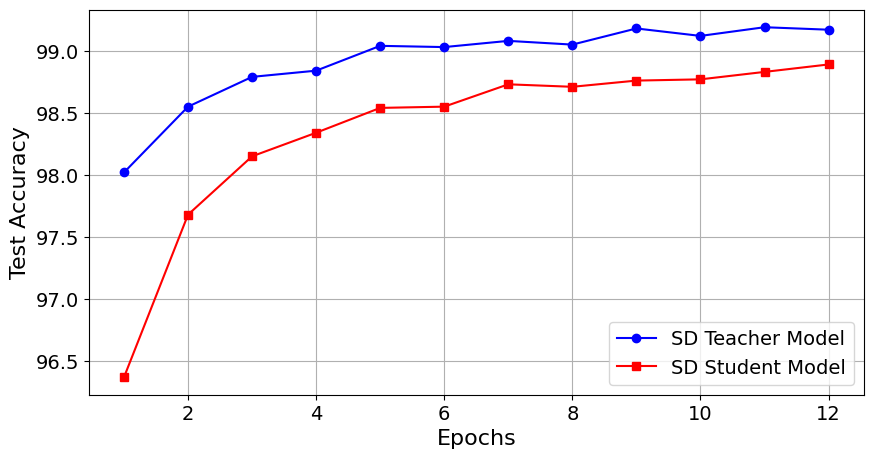

In [81]:
epochs = list(range(1, 13))

plt.figure(figsize=(10, 5))
plt.plot(epochs, SD_teacher_test_accuracies, marker='o', linestyle='-', color='b', label='SD Teacher Model')
plt.plot(epochs, SD_student_test_accuracies, marker='s', linestyle='-', color='r', label='SD Student Model')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
# plt.title('Test Accuracy vs. Number of Epochs')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)


plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T1Q12.png', dpi=300, bbox_inches='tight')

plt.show()

The use of subclass distillation for MNIST dataset on the given two model architectures doesn't further improve the student model's performance. This is expected since subclass distillation is most useful in cases where there are only a few classes. In our classification problem, there are 10 classes, which already allows a sufficient amount of information about the generalization tendencies of teacher model to be transferred to student model. Adding more subclasses will not further improve the classification performance but will incur additional complexity to the knowledge distillation process.

# Question 13

**XAI method to explain models**

In [64]:
def compute_saliency(model, input_image):
    # Convert the input image into a batch of size 1
    input_image_batch = tf.expand_dims(input_image, 0)

    # Watch the input pixels
    with tf.GradientTape() as tape:
        tape.watch(input_image_batch)

        # Predict the class scores
        predictions = model(input_image_batch)

        # Get the prediction for the top class
        top_class = tf.argmax(predictions[0])
        top_class_value = predictions[0][top_class]

    # Get the gradients of the top class with respect to the input
    grads = tape.gradient(top_class_value, input_image_batch)

    # grads tensor has shape [batch_size, height, width, channels]
    # MNIST has only one channel
    saliency = tf.abs(grads)[0, :, :, 0]

    return saliency

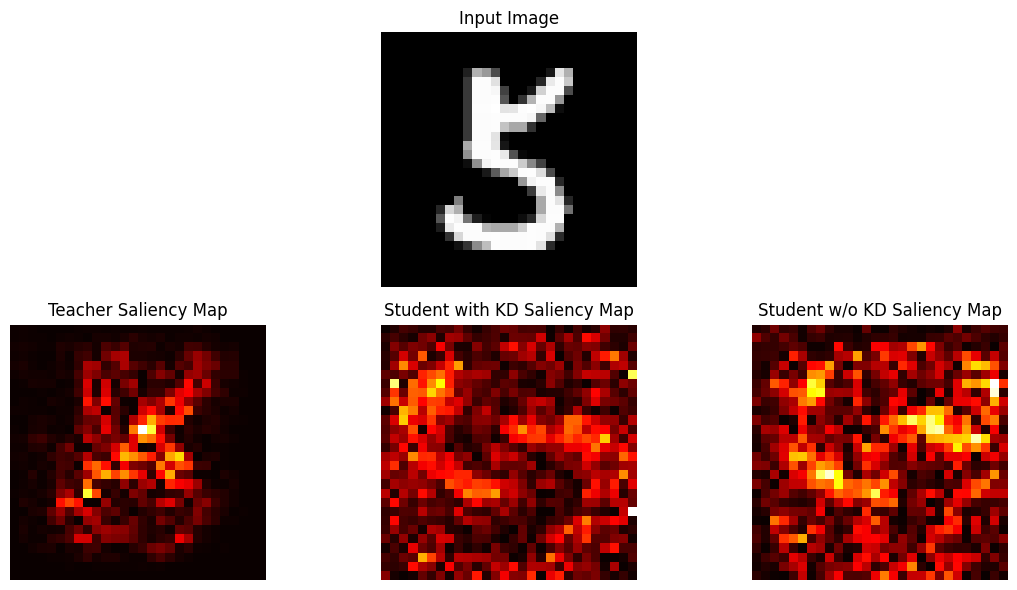

In [84]:
import random

# Choose a sample image
# sample_image = next(iter(mnist_test))[0][0]

# Choose a random index
# Convert the mnist_test dataset to a list for easier indexing
mnist_test_list = list(mnist_test)
# Choose a random sample image
random_index = random.randint(0, len(mnist_test_list) - 1)
# sample_image = mnist_test_list[random_index][0][0]
# sample_image = mnist_test_list[24][0][0]
# sample_image = mnist_test_list[39][0][0]
sample_image = mnist_test_list[4][0][0]

# Compute saliency for each model
saliency_teacher = compute_saliency(cnn_model, sample_image)
saliency_student_KD = compute_saliency(fc_model, sample_image)
saliency_student_without_KD = compute_saliency(fc_model_no_distillation, sample_image)

# Plot
plt.figure(figsize=(15, 6))

# Input Image
plt.subplot(2, 4, 2)
plt.title('Input Image')
plt.imshow(sample_image[:, :, 0], cmap='gray')
plt.axis('off')

# Teacher Saliency Map
plt.subplot(2, 4, 5)
plt.title('Teacher Saliency Map')
plt.imshow(saliency_teacher, cmap='hot')
plt.axis('off')

# Student with KD Saliency Map
plt.subplot(2, 4, 6)
plt.title('Student with KD Saliency Map')
plt.imshow(saliency_student_KD, cmap='hot')
plt.axis('off')

# Student without KD Saliency Map
plt.subplot(2, 4, 7)
plt.title('Student w/o KD Saliency Map')
plt.imshow(saliency_student_without_KD, cmap='hot')
plt.axis('off')

plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T1Q13.png', dpi=300, bbox_inches='tight')

plt.show()

I used saliency maps to highlight the most influential parts of the input for the given prediction. By comparing the saliency maps of the teacher and student models, I tried to understand which parts of the input different models focus on to make their predictions. However, the saliency map comparison doesn't provide me too much insights about the behavior of different models and their similarities. My guess is that different models, e.g., teacher model and student model, have different architectures, which means they might focus on different aspects of the input. For instance, CNNs, i.e.,teacher model, tend to focus on local patterns, while fully connected networks, i.e., student with/without KD, might distribute their attention more globally. This can cause the saliency maps to look quite different.

However, the student model with KD has a different saliency map from the student model without KD, suggesting that the process of Knowledge Distillation does influence the way the Student model "sees" or "interprets" the input. Knowledge Distillation seems to provide the student with some insights from the Teacher, guiding its focus. In addition, it appears that the student model with KD has mimicked some aspects from the teacher model, albeit in a different manner. The brighter regions in the teacher's saliency map, which indicate areas of higher influence for its prediction, correspond to darker regions in the student with KD's saliency map, suggesting those areas are of lesser influence for the student's prediction. In other words, the part of input that is most influential (bright) to teacher's prediction is roughly the part that is least influential (dark) to the student model's prediction.